In [2]:
import pandas as pd
import numpy as np
import dotenv
import os
from pathlib import Path
from ktools.utils.find_kaggle_datasets import find_competition_info

In [ ]:
dotenv.load_dotenv()
data_dir = Path(os.getenv("DATA_DIR"))
train_csv_path, test_csv_path, sample_sub_csv_path, target_col_name = find_competition_info(data_dir / "diabetes_prediction")
train_df = pd.read_csv(train_csv_path, index_col=0)
test_df = pd.read_csv(test_csv_path, index_col=0)

True

In [8]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score


def adversarial_validation(train: pd.DataFrame, test: pd.DataFrame):

    train['is_train'] = 1
    test['is_train'] = 0

    combined = pd.concat([train, test], ignore_index=True)

    X = combined.drop(columns=['is_train'])
    X = X.select_dtypes(include=['category', 'object']).astype('category')
    y = combined['is_train']

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    predictions = np.empty(len(y))

    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = XGBClassifier(enable_categorical=True, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        auc = roc_auc_score(y_val, y_pred)
        print(f'Fold AUC: {auc:.4f}')

        predictions[val_index] = y_pred

    return predictions, y

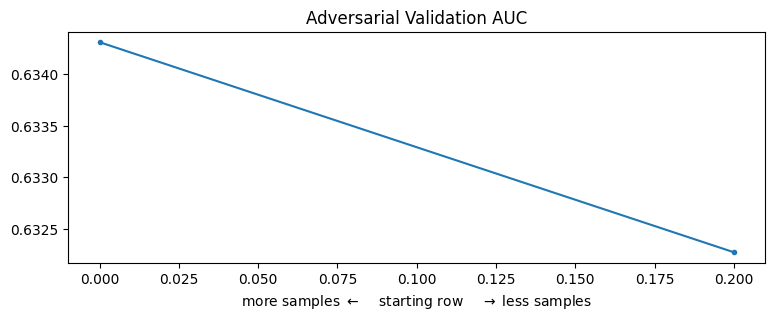

In [9]:
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

def av(X1, X2):
    X = pd.concat([X1, X2])
    X = X.astype({c: 'category' for c in X.columns if X[c].dtype=='object'})
    y = np.array([1]*len(X1)+[0]*len(X2))
    return cross_val_score(
        XGBClassifier(
            enable_categorical=True,
            n_jobs=4, random_state=0
        ), X, y, n_jobs=1,
        cv=StratifiedKFold(5, shuffle=True, random_state=0),
        scoring='roc_auc'  
    ).mean()

# train = pd.read_csv('/kaggle/input/playground-series-s5e12/train.csv', index_col='id')
# test = pd.read_csv('/kaggle/input/playground-series-s5e12/test.csv', index_col='id')
train_df.pop('diagnosed_diabetes')

start = np.array([0, 0.2])
scores = []
for r in start:
    scores.append(av(train_df.iloc[int(r*len(train_df)):], test_df))

plt.subplots(figsize=(9,3))
plt.plot(start, scores, '.-')
plt.xlabel(r'more samples $\leftarrow\quad$ starting row $\quad\rightarrow$ less samples')
plt.title('Adversarial Validation AUC')
plt.show()

In [11]:
combined = pd.concat([train_df, test_df])
# combined.drop(columns=target_col_name, inplace=True)
# X = combined.drop(columns=['is_train'])
X = combined.astype({c: 'category' for c in combined.columns if combined[c].dtype=='object'})
y = pd.Series([1]*len(train_df)+[0]*len(test_df))

In [12]:
from sklearn.base import BaseEstimator


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
predictions = np.empty(len(y))

for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model: BaseEstimator = XGBClassifier(enable_categorical=True, random_state=0, scale_pos_weight=3/7)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:,1]

    auc = roc_auc_score(y_val, y_pred)
    print(f'Fold AUC: {auc:.4f}')

    predictions[val_index] = y_pred

Fold AUC: 0.6341
Fold AUC: 0.6344
Fold AUC: 0.6372
Fold AUC: 0.6329
Fold AUC: 0.6320


In [13]:
deviation = np.abs(y - predictions)

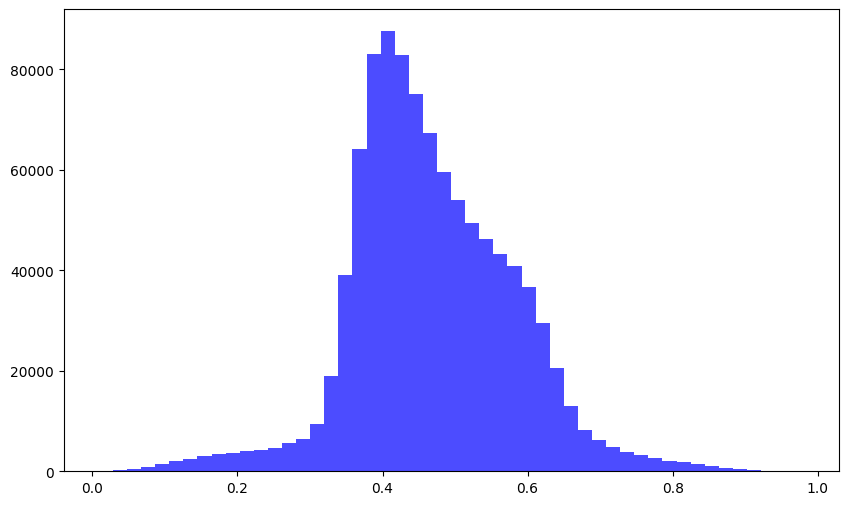

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(deviation, bins=50, color='blue', alpha=0.7)
plt.show()

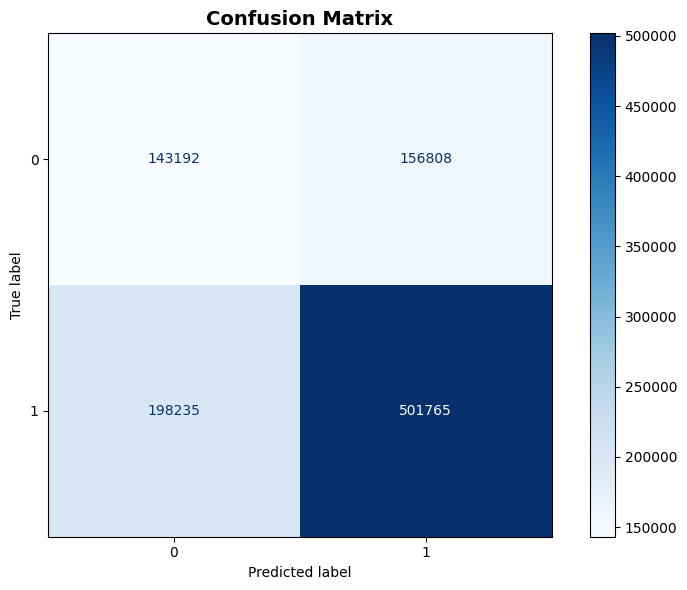

Confusion Matrix:
[[143192 156808]
 [198235 501765]]

Accuracy: 64.50%
Total samples: 1000000


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

actual = y
predicted = (predictions >= 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(actual, predicted)

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                               display_labels=np.unique(actual))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print metrics
print("Confusion Matrix:")
print(cm)
print(f"\nAccuracy: {np.trace(cm) / np.sum(cm):.2%}")
print(f"Total samples: {np.sum(cm)}")

In [16]:
mask = (predicted == 0) & (actual == 1)

In [17]:
most_similar_idcs_to_test = np.arange(len(y))[mask]

In [18]:
most_similar_idcs_to_test

array([     0,      2,      6, ..., 699991, 699994, 699997],
      shape=(198235,))

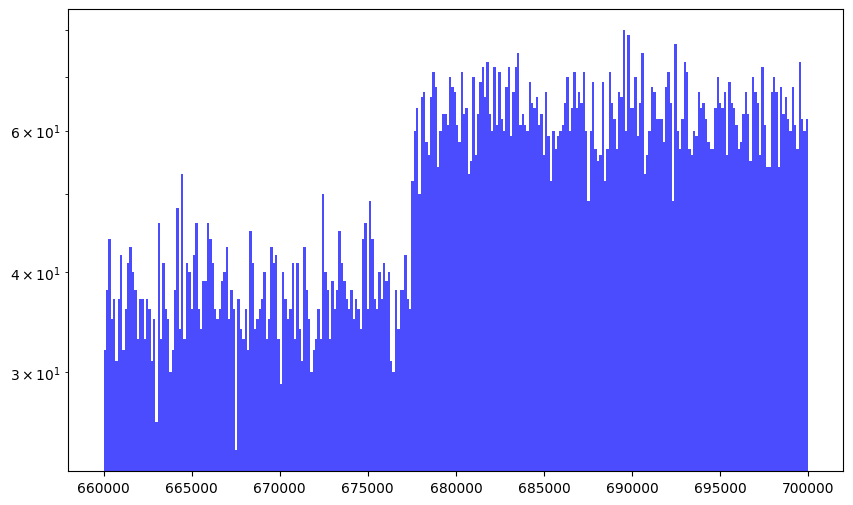

In [31]:
plt.figure(figsize=(10, 6))
values, bins, _ = plt.hist(most_similar_idcs_to_test[most_similar_idcs_to_test > 660000], bins=300, color='blue', alpha=0.7)
plt.yscale('log')
plt.show()  

In [33]:
values

array([32., 38., 44., 35., 37., 31., 37., 42., 32., 36., 41., 43., 40.,
       38., 33., 37., 37., 33., 37., 36., 31., 35., 26., 46., 33., 41.,
       36., 35., 30., 32., 38., 48., 34., 53., 33., 41., 40., 36., 42.,
       46., 36., 34., 39., 39., 46., 44., 41., 36., 35., 36., 39., 40.,
       43., 35., 38., 36., 24., 37., 34., 33., 36., 32., 45., 41., 34.,
       35., 36., 37., 40., 33., 35., 43., 41., 42., 33., 29., 40., 37.,
       35., 36., 41., 33., 41., 34., 31., 43., 38., 35., 30., 32., 33.,
       36., 33., 50., 40., 38., 33., 39., 36., 38., 45., 41., 39., 37.,
       36., 38., 35., 37., 36., 34., 44., 46., 36., 49., 44., 37., 36.,
       40., 37., 41., 39., 40., 31., 30., 38., 34., 38., 38., 42., 37.,
       36., 52., 60., 64., 50., 66., 67., 58., 56., 66., 71., 68., 54.,
       60., 63., 63., 61., 70., 68., 67., 61., 58., 71., 63., 64., 53.,
       55., 70., 56., 63., 69., 72., 66., 73., 63., 60., 72., 61., 71.,
       62., 60., 68., 72., 59., 67., 72., 75., 61., 63., 61., 60

In [41]:
bins

array([660005.        , 660138.30666667, 660271.61333333, 660404.92      ,
       660538.22666667, 660671.53333333, 660804.84      , 660938.14666667,
       661071.45333333, 661204.76      , 661338.06666667, 661471.37333333,
       661604.68      , 661737.98666667, 661871.29333333, 662004.6       ,
       662137.90666667, 662271.21333333, 662404.52      , 662537.82666667,
       662671.13333333, 662804.44      , 662937.74666667, 663071.05333333,
       663204.36      , 663337.66666667, 663470.97333333, 663604.28      ,
       663737.58666667, 663870.89333333, 664004.2       , 664137.50666667,
       664270.81333333, 664404.12      , 664537.42666667, 664670.73333333,
       664804.04      , 664937.34666667, 665070.65333333, 665203.96      ,
       665337.26666667, 665470.57333333, 665603.88      , 665737.18666667,
       665870.49333333, 666003.8       , 666137.10666667, 666270.41333333,
       666403.72      , 666537.02666667, 666670.33333333, 666803.64      ,
       666936.94666667, 6

In [35]:
bins[:-1][values == 52]

array([677468.17333333, 685333.26666667, 688399.32      ])

In [38]:
target_col = 'physical_activity_minutes_per_week'
window_size = 100
rolling_mean = train_df[target_col].rolling(window=window_size).mean()

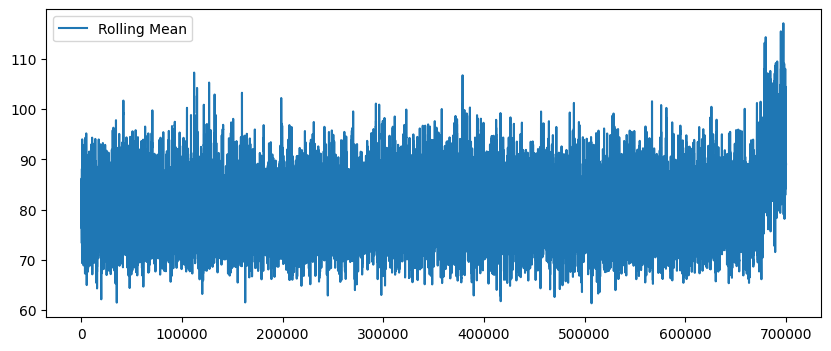

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(train_df.index, rolling_mean, label='Rolling Mean', color='tab:blue')
plt.legend()
plt.show()